# Lab 2: Network Intrusion Detection

In [17]:
# Imports
from matplotlib import pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold


from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
#from sklearn.decomposition import RandomizedPCA 
from sklearn.decomposition import PCA
from sklearn.lda import LDA

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn import metrics as mt

import seaborn as sns
import pandas as pd
import numpy as np


%matplotlib inline

In [6]:
# Load UNSW_NB15 into a Pandas dataframe
df = pd.read_csv('UNSW_NB15_training_set.csv', encoding='utf-8-sig')
df_five = df[['sttl','ct_dst_sport_ltm', 'ct_src_dport_ltm', 'swin', 'dwin', 'label' ]] # 


# Remove the four duplicate rows with invalid value for is_ftp_login
df = df[df.is_ftp_login != 2]

## Data Preparation:

* Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [7]:
# Lets remove attributes that are not useful to us during this first analysis pass
non_useful_features_list = ['id', 'attack_cat']
# id: n internal variable to just ref an obseration. deemed not usefl
# attack_cat: first try and just predict the label. 
#             It will obviously 1:1 correlate with label
#             We can circle back and swap it out with label 
#             to see if we get any better accuracy on an 
#             on an attack type level
for feature in non_useful_features_list:
    if feature in df:
        df.drop(feature, axis=1, inplace=True)  # Lets drop id as it is an internal variable to just ref an obseratio
        
# Overwrite the existing dataframe with the new dataframe that does not contain the 
# four unwanted records and confirm we have 4 less records (shold have 82328 observations)
if "is_ftp_login" in df:
    df = df[df.is_ftp_login != 2]
    if len(df) == 82328:
        print "duplicate record deleted successfully: " + str(len(df)) + " observations remaining" 
        
# Check to see if non useful features still exist in dataframe, if so, we did something wrong
for feature in non_useful_features_list:
    if feature in df:
        print "[" + feature + "]" + "still found, check removal code. (Should not see this)"        

duplicate record deleted successfully: 82328 observations remaining


In [12]:
# http://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers

# Surrounding code in try/except on case where there are no object type features to one-hot encode
try:
    tmp_df = df.describe(include=['O'])  # creates a temporary df with just categorical features that are of object type
    categorical_object_col_name_list = tmp_df.columns.values.tolist()
    for col_name in categorical_object_col_name_list:
        #print col_name
        tmp_df = pd.get_dummies(df[col_name], prefix=col_name)
        df = pd.concat((df,tmp_df), axis=1)
        df.drop(col_name, axis=1, inplace=True)  # go ahead and drop original feature as it has now been one-hot encoded
except ValueError as e:
    print "Value error({0}): ".format(e)  # Note

Value error(No objects to concatenate): 


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(162), int64(29)
memory usage: 120.6 MB


In [ ]:
# scale the features between 0 and 1 to a standrdize unit siz so that 
# downstream classification algorithms do not overfit due to 
# overlize large scaled features.


In [14]:
dfcopy = df.copy(deep=True) # preserve original dataframe that has our dependent variable
dfcopy.info()
# we want to predict the X and y data as follows:
if 'label' in dfcopy:
    y = dfcopy['label'].values # get the labels we want
    del dfcopy['label'] # get rid of the class label
    X = dfcopy.values # use everything else to predict!
dfcopy.info() # should have 190 entries
    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn

# determine if we have roughly the same percentage of  normal vs abnormal observations
# ref: http://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray-in-python
# ref: http://www.gossamer-threads.com/lists/python/python/809232 (print percentage)
unique, counts = np.unique(y, return_counts=True)
uniqueClassCounts = dict(zip(unique, counts))    
totalObservations = len(y)
print uniqueClassCounts
print "Percent normal(0) is {0:.0%}".format(float(uniqueClassCounts[0])/totalObservations)
print "Percent attack(1) is {0:.0%}".format(float(uniqueClassCounts[1])/totalObservations)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(162), int64(29)
memory usage: 120.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 190 entries, dur to state_RST
dtypes: float64(162), int64(28)
memory usage: 120.0 MB
{0: 37000, 1: 45328}
Percent normal(0) is 45%
Percent attack(1) is 55%


ref:
(a) http://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation
(b) http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
(c) http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/


Per ref (a) startification in general seeks to ensure each fold is representative of all strata in the data. The label feature has two classes (categories) as seen above normal(0) and attack(1) with percentages of 45% and 55%, respectively based on distribution of the classes with respect to the complete dataset. If it was 50%/50% one could argue a random sampling should create evenly distributed folds and with large enough sample size, should be sufficient. The main argument for stratification is to address the biasing effects of classification algorithms based on over/under representation of classes in any one particular sample or folds for classification algorithms that do not inherently have inherent balancing techniques either by selection or weighting.  According to ref (a), however, it does lead to a loss of diversity (unwanted loss of variance). Basically, the more unbalanced then the classes are, the more biased a classification algorithm in general would be to the observations tending to the more popular class. Stratification seeks to correct for that artificially to address algorithms that cleverly try and predict the class witht the highest weighting based on class distribution.

Since the values in the labels are not exactly equal, a stratified Kfold validation is recommended so that each set or fold contains approximately the same percentage of samples of each target class as the complete set.
Note: Will do both for comparision sake to see if there is any difference
in results and to get a feel for the methodology.

Note: per ref (a) To combat imbalanced training data, one technique woudl be to try and colect more data with a larger dataset.  However. since we did not generate this data ourselves, this would not be an option.

Another thing that we can do to to measure performance is to selecting the right set of performance metrics beyond the arguably defalt one which is accuracy.  

With our particular dataset there are a couple of different view points on which performance metrics a model should be tuned for for this particular dataset:
1) False negatives are probably worse than false positives. If a malicious packet gets through undetected, it could potentially do bad things without being noticed, whereas a false positive could be rescreened or reviewed to clear the packet. Note: however, if the system has protection in depth, perhaps down stream systems may catch the packet or some effect of the malicous abnormal packet (e.g. host based intrusion detection system, so it may not be that bad).
Recall may be a good metric to gauge model performance based on highlighting false negatives. Recall is defined as the number of True Postivies divided by the number of True Positives and the number of False Negatives, also known as Sensitivity or the True Postive Rate. 

2) However, if there are too may false positives, where the system over classifies packets as malcious when they really aren't then it could be interfering with normal operations and impact business operations. On the assumption that it takes some signficant amount of time to clear a tagged (false) positive packet. If a tool identifies too many false positives, people would lose trust with the system. Based on this view, precision which is defined as the number of True Positives divided by the number of True Positives and False positives would be a good metric to use to gauge performance of models used for predicting abnormal packets.

3) Based on these view points, a metric which combines both would be the F1 Score which is 2*((precision*recall)/(precision+recall)) also know as the F Score or F Measure which tries to convey the balance between precision and recall. 

The Variance Threshold transformer would automatically remove  any fetures that hav no variance. Although there are some small variance, there are alot of small variances. Based on not having enough domain knowledge of any individual feature what what would a reasonable threshold value to use, we will continue to use all of them and perhaps apply a different technique to reduce the number of features. Lets perhaps try PCA to see how many principal components we would need to maintain explain at least 90% of the variation in an effort to reduce the number of features for downstream classification tasks to improve performance in classification tasks. (Ref: Book: Learning Data Mining with Python)



In [23]:
# Use Variance Threshold transformer in scikit-learn to remove any feature
# that does have a minimum level of variance, using 0 as threshold
# based on limited domain knowledge. 
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold()
Xt = vt.fit_transform(X)
print vt.variances_
if len(Xt[0]) < 190:
    print "we found some features to have 0 variance and hence will remove them"
else:
    print "We didn't find any features to have 0 variance, moving on."
print len(Xt[0])

[  2.21890799e+01   1.79342396e+04   1.33578532e+04   2.94621370e+10
   2.29444304e+10   2.20884887e+10   1.03046496e+04   1.36106665e+04
   3.23512553e+16   5.72664168e+12   4.17972493e+03   3.10349621e+03
   3.82261060e+07   1.67030265e+06   3.21772939e+09   1.32158617e+07
   1.62196787e+04   1.93451972e+18   1.90998275e+18   1.62538616e+04
   1.34613899e-02   5.02036285e-03   3.03537401e-03   4.34618776e+04
   5.98313643e+04   2.94774411e-01   1.44914706e+09   1.22996215e+02
   1.13892530e+00   7.08670434e+01   7.03866176e+01   3.49929328e+01
   1.30310762e+02   8.11974201e-03   8.36107223e-03   4.07929478e-01
   7.30010471e+01   1.23687849e+02   1.10024339e-02   3.88538067e-04
   3.88538067e-04   3.88538067e-04   1.16470772e-03   4.00675012e-04
   3.88538067e-04   1.18449036e-02   3.88538067e-04   4.12811663e-04
   3.88538067e-04   3.88538067e-04   4.00675012e-04   3.88538067e-04
   4.00675012e-04   3.88538067e-04   3.88538067e-04   3.88538067e-04
   3.88538067e-04   3.88538067e-04

In [15]:
# Scale data to have zero mean and unit variance to ensure that
# down stream classification algorithms that are sensitive and unfairly 
# weight association due to large scaled features  are densensitized to that
# effect. Also when performing PCA for feature redution, since PA yields a feature
# subspace that maximizes variance along the axes, it makes sense to standardize
# the data, especially since the features appear to be on different scales.

scaler = preprocessing.StandardScaler().fit(X)
scaler.mean_
scaler.scale_
scaler.transform(X)

array([[-0.21372809, -0.12445524, -0.15181591, ...,  1.18737468,
        -0.15128109, -0.00348521],
       [-0.21372873, -0.12445524, -0.15181591, ...,  1.18737468,
        -0.15128109, -0.00348521],
       [-0.21372936, -0.12445524, -0.15181591, ...,  1.18737468,
        -0.15128109, -0.00348521],
       ..., 
       [-0.21373043, -0.13192245, -0.15181591, ...,  1.18737468,
        -0.15128109, -0.00348521],
       [-0.21373043, -0.13192245, -0.15181591, ...,  1.18737468,
        -0.15128109, -0.00348521],
       [-0.21372851, -0.12445524, -0.15181591, ...,  1.18737468,
        -0.15128109, -0.00348521]])

[  3.12577565e+18   7.21829322e+17   2.92489964e+16   5.49388956e+12
   2.94308575e+10   2.28671040e+10   1.31082682e+10   3.18421633e+09
   1.22443421e+09   3.70924227e+07   8.48041068e+06   7.99521381e+05
   3.59673237e+04   2.96460691e+04   1.05545522e+04]
[  8.06264871e-01   1.86189186e-01   7.54450766e-03   1.41709791e-06
   7.59141703e-09   5.89835762e-09   3.38115635e-09   8.21339103e-10
   3.15831460e-10   9.56764680e-12   2.18744337e-12   2.06229133e-13
   9.27743792e-15   7.64692887e-15   2.72244896e-15]


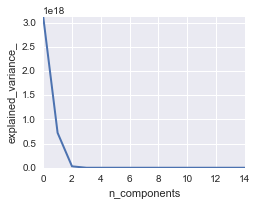

In [38]:
from sklearn import linear_model, decomposition, datasets

pca = decomposition.PCA()
pca.fit(X)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_[:15], linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
print pca.explained_variance_[:15]



[  8.06264871e-01   1.86189186e-01   7.54450766e-03   1.41709791e-06
   7.59141703e-09   5.89835762e-09   3.38115635e-09   8.21339103e-10
   3.15831460e-10   9.56764680e-12   2.18744337e-12   2.06229133e-13
   9.27743792e-15   7.64692887e-15   2.72244896e-15]


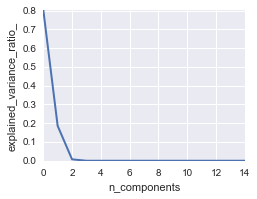

In [40]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_[:15], linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
print pca.explained_variance_ratio_[:15]

In [43]:
sum(pca.explained_variance_ratio_[:2]) 

0.99245405722335422

It appears the 1st two components accounts for 99% of the variation.
lets create a pipeline of PcA and Logistic Regression


In [18]:

logistic = linear_model.LogisticRegression()
pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca),
                       ('logistic', logistic)])
#Parameters of pipelines can be set using ‘__’ separated parameter names:
grid = dict(pca__n_components=[1, 2, 3],
            logistic__C=[1e-4, 1.0, 1e4],
            logistic__penalty=['l1', 'l2'])
estimator = GridSearchCV(pipe, grid, n_jobs=-1)
%time estimator.fit(X, y)

Wall time: 6min 43s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'logistic__C': [0.0001, 1.0, 10000.0], 'pca__n_components': [1, 2, 3], 'logistic__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [52]:
print "best score = " + str(estimator.best_score_)
print estimator.best_params_

best score = 0.670440190458
{'logistic__C': 0.0001, 'pca__n_components': 3, 'logistic__penalty': 'l1'}


It is interesting that grid search discovere pca__n_components =3 to be part of the best parameter as the 3 component only contributed less than 1% to the variance. For curiosity sake, run again, but leave out 3 as a component to try out to see what the best score looks like

In [53]:
grid = dict(pca__n_components=[1, 2],
            logistic__C=[1e-4, 1.0, 1e4],
            logistic__penalty=['l1', 'l2'])
estimator = GridSearchCV(pipe, grid, n_jobs=-1)
%time estimator.fit(X, y)
print "best score = " + str(estimator.best_score_)
print estimator.best_params_

Wall time: 3min 11s
best score = 0.665690894957
{'logistic__C': 0.0001, 'pca__n_components': 1, 'logistic__penalty': 'l1'}


ref: 
(a) http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html
(b) http://matthewrocklin.com/blog/work/2016/07/12/dask-learn-part-1
Note: I was expecting pca__n_components to be 2 since there seemed to be a significant jump from 90-99% variance explanation, but the grid search decided that only 1 was necessary to create the best score. the other parameters remained the same and the score only dropped by roughly .01. It also shaved processing time in about half. Based on ref (b) scikit-learns gird search also does cross aliation across 3-folds by default). Each estimator was fit on its corresponding testing data and and then scored on corresponding set of testing data. 


In [21]:
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest
# This dataset is way too high-dimensional. Better do PCA:
pca = decomposition.PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)
# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)
pipeline = Pipeline(steps=[("features", combined_features), ('logistic', logistic)])
grid = dict(pca__n_components=[1, 2],
            logistic__C=[1e-4, 1.0, 1e4],
            logistic__penalty=['l1', 'l2'])
estimator = GridSearchCV(pipe, grid, n_jobs=-1, verbose=10)
%time estimator.fit(X, y)
print(grid_search.best_estimator_)
print("best score = " + str(estimator.best_score_))
print(estimator.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:  2.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  3.0min remaining:   43.2s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  3.1min remaining:   17.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.3min finished


Wall time: 3min 31s


NameError: name 'grid_search' is not defined

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
#ref : http://stackoverflow.com/questions/2866380/how-can-i-time-a-code-segment-for-testing-performance-with-pythons-timeit
import time
#ref: http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html
numObservations = len(dfcopy)
print numObservations
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold

y = dfcopy['label'].values
numObservations = len(dfcopy)
num_folds = 10
kf = KFold(numObservations, n_folds=num_folds)
skf = StratifiedKFold(y, num_folds)

# first we create a reusable logisitic regression object
# here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
print(kf)
t0 = time.clock()

for train_index, test_index in kf:
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)
t1 = time.clock()
total = t1 - t0

accuracies = cross_val_score(lr_clf, X, y=y, cv=kf) # this also can help with parallelism
#print(accuracies)
print "Average Accuracy across " + str(num_folds) + " fold cross validation iterations = " + str(np.average(accuracies)) + " training time = " + str(total)    

t0 = time.clock()
for train_index, test_index in skf:
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test)
t1 = time.clock()
total = t1 - t0
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
# http://scikit-learn.org/stable/modules/model_evaluation.html
accuracies = cross_val_score(lr_clf, X, y=y, cv=skf) # this also can help with parallelism
precision = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='precision')
recall = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='recall')
accuracy = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='accuracy')
f1 = cross_val_score(lr_clf, X, y=y, cv=skf, scoring='f1')# just testing to see if it is same as default
#print(accuracies)
#print "Percent normal(0) is {0:.0%}".format(float(classCounts[0])/totalObservations)
print "Average Accuracies across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%} ".format(np.average(accuracies)) + " training time = " + str(total)    
print "Average Precision across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(precision)) + " training time = " + str(total)    
print "Average Recall(Sensitivity) across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(recall)) + " training time = " + str(total)    
print "Average Accuracy across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(accuracy)) + " training time = " + str(total)    
print "Average F measure(F1) across stratified " + str(num_folds) + " fold cross validation iterations = {0:.0%}".format(np.average(f1)) + " training time = " + str(total)    

# http://stackoverflow.com/questions/23339523/sklearn-cross-validation-with-multiple-scores
from sklearn import metrics
def mean_scores(X, y, clf, skf):

    cm = np.zeros(len(np.unique(y)) ** 2)
    for i, (train, test) in enumerate(skf):
        clf.fit(X[train], y[train])
        y_pred = clf.predict(X[test])
        cm += metrics.confusion_matrix(y[test], y_pred).flatten()

    return compute_measures(*cm / skf.n_folds)

def compute_measures(tp, fp, fn, tn):
     """Computes effectiveness measures given a confusion matrix."""
     specificity = tn / (tn + fp)
     sensitivity = tp / (tp + fn)
     fmeasure = 2 * (specificity * sensitivity) / (specificity + sensitivity)
     return sensitivity, specificity, fmeasure
    
print mean_scores(X, y, lr_clf, skf)

82328
sklearn.cross_validation.KFold(n=82328, n_folds=10, shuffle=False, random_state=None)
Average Accuracy across 10 fold cross validation iterations = 0.606487290653 training time = 10.2802627327
Average Accuracies across statified 10 fold cross validation iterations = 75%  training time = 10.3222235803
Average Precision across statified 10 fold cross validation iterations = 85% training time = 10.3222235803
Average Recall(Sensitivity) across statified 10 fold cross validation iterations = 66% training time = 10.3222235803
Average Accuracy across statified 10 fold cross validation iterations = 75% training time = 10.3222235803
Average F measure(F1) across statified 10 fold cross validation iterations = 73% training time = 10.3222235803
(0.67579947052149436, 0.86077042667127313, 0.75715162668194602)


The stratified 10 fold cross validation appears to have a higher accuracy score of 75% vs 61%. Not much difference in computational expense between the two cross validation methods.
    # https://uberpython.wordpress.com/2012/01/01/precision-recall-sensitivity-and-specificity/
   
   Sensitivy/recall measures how good the model is at detecting the positives, which somewhat important.
However, 

* Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [56]:
#ref: http://matthewrocklin.com/blog/work/2016/07/12/dask-learn-part-1

from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000,
                           n_features=500,
                           n_classes=2,
                           n_redundant=250,
                           random_state=42)

In [57]:
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression()
pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca),
                       ('logistic', logistic)])


In [ ]:
#Parameters of pipelines can be set using ‘__’ separated parameter names:
grid = dict(pca__n_components=[50, 100, 250],
            logistic__C=[1e-4, 1.0, 1e4],
            logistic__penalty=['l1', 'l2'])

scores = ['precision', 'recall', 'f1', 'accuracy']

#grid = dict(pca__n_components=[50],
#            logistic__C=[1e-4],
#            logistic__penalty=['l2'])

In [70]:
from sklearn.grid_search import GridSearchCV
from __future__ import print_function

for score in scores:
    estimator = GridSearchCV(pipe, grid, n_jobs=-1, scoring='%s' % score)
    %time estimator.fit(X, y)
    print(score + " " + str(estimator.best_score_))


Wall time: 32.8 s
precision 0.89184751014
Wall time: 35.7 s
recall 0.8948
Wall time: 34.8 s
f1 0.893126414374
Wall time: 35.2 s
accuracy 0.8928


In [7]:
estimator.best_score_

0.8928

In [8]:
estimator.best_params_

{'logistic__C': 0.0001, 'logistic__penalty': 'l2', 'pca__n_components': 50}

In [55]:
# ref: http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html

from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    # http://stackoverflow.com/questions/1614236/in-python-how-to-i-convert-all-items-in-a-list-to-floats
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in digits.target_names.tolist()]))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'kernel': 'rbf', 'C': 10, 'gamma': 0.001}

Grid scores on development set:

0.986 (+/-0.016) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.959 (+/-0.029) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.988 (+/-0.017) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.982 (+/-0.026) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.988 (+/-0.017) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.982 (+/-0.025) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.988 (+/-0.017) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
0.982 (+/-0.025) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
0.975 (+/-0.014) for {'kernel': 'linear', 'C': 1}
0.975 (+/-0.014) for {'kernel': 'linear', 'C': 10}
0.975 (+/-0.014) for {'kernel': 'linear', 'C': 100}
0.975 (+/-0.014) for {'kernel': 'linear', 'C': 1000}

Detailed classification report:

The model 

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
## Modeling and Evaluation:
* Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

*  Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

*  Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms! 

*  Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

* Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation. 

* Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

## Deployment:
* How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

## Exceptional Work: